In [1]:
suppressPackageStartupMessages(library(dplyr)) 
library(ggplot2)
library(pheatmap)
library(RColorBrewer)
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(Signac))
source("~/scratch/28.FC_16k_Droplet_PT_221210/05.R/DPT_help.R") ### helper code

In [2]:
getwd()
subdir <- "."

[1] "/oasis/tscc/scratch/y2xie/28.FC_16k_Droplet_PT_221210/05.R/Preprocess"

# Cicero (gene-cCRE pairs)
### run_Cicero.R

## Calculate correlation: H3K27ac

In [11]:
p1 <- readRDS("FC_H3K27acCEMBA_cCRE.rds")
mmg <- readRDS("FC_RNA_Seurat_merged_rmScrublet.rds")
p2 <- readRDS("FC_H3K27me3CEMBA_cCRE.rds")

In [5]:
valid <- rownames(p1@meta.data[p1$RNA_keep_cells != "False" & p1$DNA_keep_cells == "True", ])
p1 <- subset(p1, cells = valid)
dmeta <- p1@meta.data[,c("nCount_DNA", "rna_Anno0.8")] %>% setNames(c("nCount_histone", "rna_Anno0.8"))
peaks <- ArcXPM(p1[["cemba"]]@counts, meta = dmeta, group.by = "rna_Anno0.8")
rna <- subset(mmg, subset = Target == "H3K27ac" & RNA_keep_cells == "True")
rmeta <- rna@meta.data[,c("nCount_RNA", "Anno0.8_yel")]
rna <- ArcXPM(rna[["RNA"]]@counts, meta = rmeta, group.by = "Anno0.8_yel", method = "RPKM")

### Filter peaks list
cre <- read.table("../cicero/CEMBA_ovlp/DPT_FC_H3K27ac_CEMBA_cCRE_cicero_conns_unfilt.xls", header = T)
cre <- cre %>% dplyr::filter(coaccess > 0.1)
cre <- cre[!is.na(cre$coaccess),]
cre <- cre[!duplicated(t(apply(cre,1,sort))), ] ### keep only one pair in A-B B-A
print(paste0("number of pairs before filtering: ", nrow(cre)))

### select distal_proximal pairs
cre_list <- unique(c(cre$Peak1, cre$Peak2))
print(paste0("number of peaks before filtering: ", nrow(peaks)))
cre_bed <- stringr::str_split_fixed(cre_list, pattern = "-", n = 3) %>% as.data.frame
cre_bed$cood <- paste(cre_bed[,1], cre_bed[,2], cre_bed[,3], sep = "-")
cre_gr <- GenomicRanges::GRanges(cre_bed[, 1], IRanges::IRanges(as.integer(cre_bed[, 2]), as.integer(cre_bed[, 3])))
tss <- read.table("/projects/ps-renlab/y2xie/projects/genome_ref/mm10.tss.vm25.2k.bed", header = F)
tss_gr <- GenomicRanges::GRanges(tss[, 1], IRanges::IRanges(tss[, 2], tss[, 3])) 
idy = S4Vectors::queryHits(GenomicRanges::findOverlaps(cre_gr, tss_gr)) ### which cres are classified as TSS-associated
pp <- cre[intersect(which(cre$Peak1 %in% cre_bed[idy, "cood"]), 
                    which(cre$Peak2 %in% cre_bed[idy, "cood"])),] %>% rownames
dd <- intersect(rownames(cre[-which(cre$Peak1 %in% cre_bed[idy, "cood"]),]), 
                rownames(cre[-which(cre$Peak2 %in% cre_bed[idy, "cood"]),]))
cre <- cre[!(rownames(cre) %in% c(pp, dd)),]
print(paste0("number of distal_proximal pairs: ", nrow(cre)))

### select gene and peak pair for calculating PCC
cre_bed <- cre
cre_bed[,c("chr1", "start1", "end1")] <- stringr::str_split_fixed(cre$Peak1, pattern = "-", n = 3)
cre_bed[,c("chr2", "start2", "end2")] <- stringr::str_split_fixed(cre$Peak2, pattern = "-", n = 3)
cre_bed$pair <- paste0("pair_", 1:nrow(cre_bed))
write.table(cre_bed[,c("chr1", "start1", "end1", "pair")], file = "tmp_left.bed", quote = F, sep = "\t", row.names = F, col.names = F)
write.table(cre_bed[,c("chr2", "start2", "end2", "pair")], file = "tmp_right.bed", quote = F, sep = "\t", row.names = F, col.names = F)
system("bedtools intersect -a tmp_left.bed -b /projects/ps-renlab/y2xie/projects/genome_ref/mm10.tss.vm25.2k.bed -wo > tmp_left_tss_ovlp.bed")
system("bedtools intersect -a tmp_right.bed -b /projects/ps-renlab/y2xie/projects/genome_ref/mm10.tss.vm25.2k.bed -wo > tmp_right_tss_ovlp.bed")
cre_left <- read.table("tmp_left_tss_ovlp.bed", header = F)
cre_right <- read.table("tmp_left_tss_ovlp.bed", header = F)

### construct pair
tmp <- merge(x = cre_bed, y = cre_left[,c(1:4,10)], by.x = "pair", by.y = "V4", all.x = T)
left_dp <- tmp[!is.na(tmp$V10), c("V10", "Peak2")] %>% setNames(c("gene", "peak"))
tmp <- merge(x = cre_bed, y = cre_right[,c(1:4,10)], by.x = "pair", by.y = "V4", all.x = T)
right_dp <- tmp[!is.na(tmp$V10), c("V10", "Peak1")] %>% setNames(c("gene", "peak"))
cre_pair <- rbind(left_dp, right_dp)
print(paste0("number of genes-distal CRE: ", nrow(cre_pair)))
peaks <- peaks[intersect(rownames(peaks), cre_pair$peak),]
print(paste0("number of peaks after filtering: ", nrow(peaks)))

### Filter gene list
gene_list1 <- rowMeans(rna) %>% log10 %>% as.data.frame() %>% setNames("logExp") %>% dplyr::filter(logExp > -1) %>% rownames
print(paste0("number of genes before filtering: ", nrow(rna)))
rna <- rna[intersect(rownames(rna), cre_pair$gene), ]
print(paste0("number of genes after filtering: ", nrow(rna)))

sparsity: 0.656728381444599
coarse dgTMatrix into Matrix.
check readSums:  20 
check obj_mtx_collapse:  20 
sparsity: 0.518914356512312
coarse dgTMatrix into Matrix.
check readSums:  20 
check obj_mtx_collapse:  20 
[1] "number of pairs before filtering: 577747"
[1] "number of peaks before filtering: 317320"
[1] "number of distal_proximal pairs: 111847"
[1] "number of genes-distal CRE: 130092"
[1] "number of peaks after filtering: 47418"
[1] "number of genes before filtering: 32285"
[1] "number of genes after filtering: 10963"


In [6]:
### shuffle as background!
mtx <- p1[["cemba"]]@counts
rownames(mtx) <- sample(rownames(mtx), nrow(mtx))
colnames(mtx) <- sample(colnames(mtx), ncol(mtx))
obj <- CreateSeuratObject(mtx, assay = "DNA", meta.data = p1@meta.data[, "rna_Anno0.8", drop = F])
dmeta <- obj@meta.data[,c("nCount_DNA", "rna_Anno0.8")] %>% setNames(c("nCount_histone", "rna_Anno0.8"))
peaks_bg <- ArcXPM(obj[["DNA"]]@counts, meta = dmeta, group.by = "rna_Anno0.8")

robj <- subset(mmg, subset = Target == "H3K27ac" & RNA_keep_cells == "True")
mtx <- robj[["RNA"]]@counts
rownames(mtx) <- sample(rownames(mtx), nrow(mtx))
colnames(mtx) <- sample(colnames(mtx), ncol(mtx))
obj <- CreateSeuratObject(mtx, assay = "RNA", meta.data = robj@meta.data[, "Anno0.8_yel", drop = F])
rmeta <- obj@meta.data[,c("nCount_RNA", "Anno0.8_yel")]
rna_bg <- ArcXPM(obj[["RNA"]]@counts, meta = rmeta, group.by = "Anno0.8_yel", method = "RPKM")

sparsity: 0.710857336442708
coarse dgTMatrix into Matrix.
check readSums:  20 
check obj_mtx_collapse:  20 
sparsity: 0.564203190336069
coarse dgTMatrix into Matrix.
check readSums:  20 
check obj_mtx_collapse:  20 


In [6]:
### spearman correltion between pairs
cre_pair <- cre_pair[cre_pair$gene %in% intersect(rownames(rna), cre_pair$gene),]
colorder <- sort(colnames(rna))
m1 <- rna %>% as.data.frame %>% dplyr::select(all_of(colorder)) %>% t %>% as.data.frame 
m2 <- peaks %>% as.data.frame %>% dplyr::select(all_of(colorder)) %>% t %>% as.data.frame 

dp_cor <- c()
dp_cor_df <- data.frame(k27ac = c(""), gene = c(""), peaks = c(""))
for(i in 1:nrow(cre_pair)){
    dp_cor[i] <- suppressWarnings(cor(m1[, cre_pair[i, "gene"]], m2[, cre_pair[i, "peak"]], method = "spearman"))
    tmp <- data.frame(k27ac = dp_cor[i], gene = cre_pair[i, "gene"], peaks = cre_pair[i, "peak"])
    dp_cor_df <- rbind(dp_cor_df, tmp)
}

peaks_bg <- peaks_bg[rownames(peaks), ]
rna_bg <- rna_bg[rownames(rna), ]
m1_bg <- rna_bg %>% as.data.frame %>% dplyr::select(all_of(colorder)) %>% t %>% as.data.frame 
m2_bg <- peaks_bg %>% as.data.frame %>% dplyr::select(all_of(colorder)) %>% t %>% as.data.frame 
dp_cor_bg <- c()
dp_cor_bg_df <- data.frame(k27ac_bg = c(""), gene = c(""), peaks = c(""))
for(i in 1:nrow(cre_pair)){
    dp_cor_bg[i] <- suppressWarnings(cor(m1_bg[, cre_pair[i, "gene"]], m2_bg[, cre_pair[i, "peak"]], method = "spearman"))
    tmp <- data.frame(k27ac_bg = dp_cor_bg[i], gene = cre_pair[i, "gene"], peaks = cre_pair[i, "peak"])
    dp_cor_bg_df <- rbind(dp_cor_bg_df, tmp)
}

### save SCC 
dp_cor_df <- dp_cor_df[-1,]
dp_cor_df <- transform(dp_cor_df, k27ac = as.numeric(k27ac))
dp_cor_df <- dp_cor_df[!is.na(dp_cor_df$k27ac),]
saveRDS(dp_cor_df, "cicero/CEMBA_ovlp/DPT_FC_H3K27ac_CEMBA_cCRE_cicero_distal_peak_RNA_SCC.rds")

dp_cor_bg_df <- dp_cor_bg_df[-1,]
dp_cor_bg_df <- transform(dp_cor_bg_df, k27ac_bg = as.numeric(k27ac_bg))
dp_cor_bg_df <- dp_cor_bg_df[!is.na(dp_cor_bg_df$k27ac_bg),]
saveRDS(dp_cor_bg_df, "cicero/CEMBA_ovlp/DPT_FC_H3K27ac_CEMBA_cCRE_cicero_distal_peak_RNA_SCC_background.rds")


In [8]:
### calculate FDR
### FDR < 0.05, meaningful pairs
df = data.frame(rho = c(dp_cor_df$k27ac, dp_cor_bg_df$k27ac_bg), 
                type = rep(c(TRUE,FALSE), times = c(nrow(dp_cor_df), nrow(dp_cor_bg_df))))
df = df[order(df$rho, decreasing = T),]
df$FP = cumsum(df$type == FALSE)
df$TP = cumsum(df$type == TRUE)
df$FDR = df$FP / (df$FP + df$TP)
df[df$FDR < 0.1,] %>% dplyr::select(rho) %>% min
df[df$FDR < 0.05,] %>% dplyr::select(rho) %>% min

[1] 0.4151498

[1] 0.5305617

In [9]:
dp_cor_df[dp_cor_df$k27ac > 0.531,] %>% nrow

[1] 20241

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


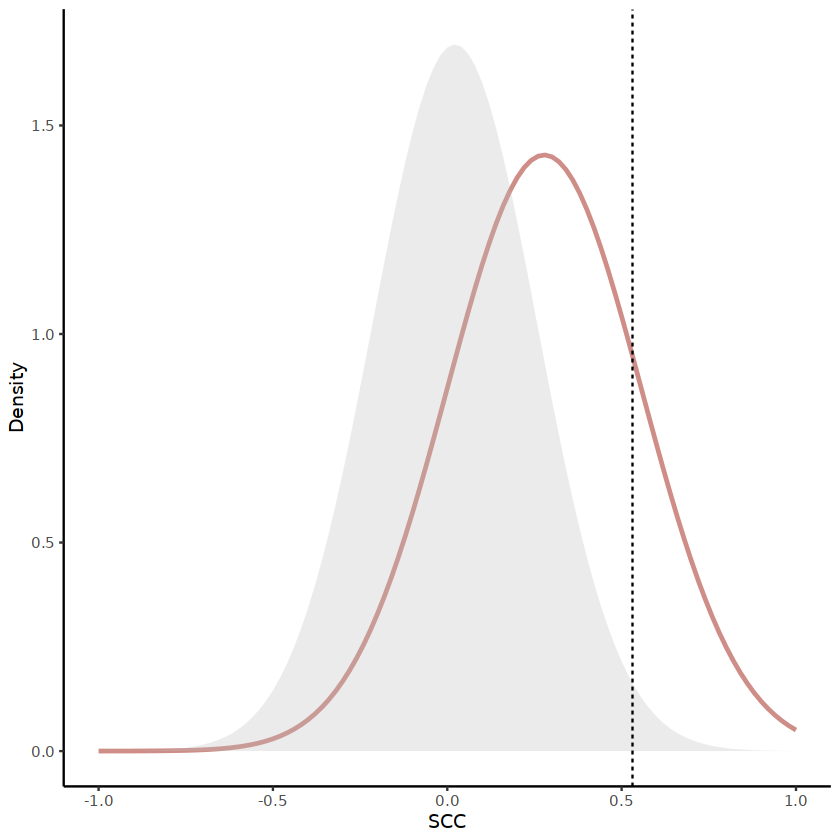

In [10]:
### Plot density
cutoff <- df[df$FDR < 0.05,] %>% dplyr::select(rho) %>% min
t1 <- dp_cor_df %>%
ggplot(aes(x = k27ac)) + 
stat_function(aes(group = 1), fun = dnorm, 
              args = list(mean = mean(dp_cor_df$k27ac), sd = sd(dp_cor_df$k27ac)),
              col = colfunc2(4)[2], size = 1, alpha = 0.6) + 
stat_function(data = dp_cor_bg_df, aes(x = k27ac_bg, group = 1), fun = dnorm, geom = 'area',
              args = list(mean = mean(dp_cor_bg_df$k27ac_bg), sd = sd(dp_cor_bg_df$k27ac_bg)),
              size = 1, fill = "grey", alpha = 0.3) + 
geom_vline(xintercept = cutoff, linetype = 2) +
theme_classic() + xlab("SCC") + ylab("Density") + xlim(c(-1,1))
t1

## Calculate correlation: H3K27me3

In [13]:
valid <- rownames(p2@meta.data[p2$RNA_keep_cells != "False" & p2$DNA_keep_cells == "True", ])
p2 <- subset(p2, cells = valid)
dmeta <- p2@meta.data[,c("nCount_DNA", "rna_Anno0.8")] %>% setNames(c("nCount_histone", "rna_Anno0.8"))
peaks <- ArcXPM(p2[["cemba"]]@counts, meta = dmeta, group.by = "rna_Anno0.8")
rna <- subset(mmg, subset = Target == "H3K27me3" & RNA_keep_cells == "True")
rmeta <- rna@meta.data[,c("nCount_RNA", "Anno0.8_yel")]
rna <- ArcXPM(rna[["RNA"]]@counts, meta = rmeta, group.by = "Anno0.8_yel", method = "RPKM")

### Filter peaks list
cre <- read.table("cicero/CEMBA_ovlp/DPT_FC_H3K27me3_CEMBA_cCRE_cicero_conns_unfilt.xls", header = T)
cre <- cre %>% dplyr::filter(coaccess > 0.1)
cre <- cre[!is.na(cre$coaccess),]
cre <- cre[!duplicated(t(apply(cre,1,sort))), ] ### keep only one pair in A-B B-A
print(paste0("number of pairs before filtering: ", nrow(cre)))

### select distal_proximal pairs
cre_list <- unique(c(cre$Peak1, cre$Peak2))
print(paste0("number of peaks before filtering: ", nrow(peaks)))
cre_bed <- stringr::str_split_fixed(cre_list, pattern = "-", n = 3) %>% as.data.frame
cre_bed$cood <- paste(cre_bed[,1], cre_bed[,2], cre_bed[,3], sep = "-")
cre_gr <- GenomicRanges::GRanges(cre_bed[, 1], IRanges::IRanges(as.integer(cre_bed[, 2]), as.integer(cre_bed[, 3])))
tss <- read.table("/projects/ps-renlab/y2xie/projects/genome_ref/mm10.tss.vm25.2k.bed", header = F)
tss_gr <- GenomicRanges::GRanges(tss[, 1], IRanges::IRanges(tss[, 2], tss[, 3])) 
idy = S4Vectors::queryHits(GenomicRanges::findOverlaps(cre_gr, tss_gr)) ### which cres are classified as TSS-associated
pp <- cre[intersect(which(cre$Peak1 %in% cre_bed[idy, "cood"]), 
                    which(cre$Peak2 %in% cre_bed[idy, "cood"])),] %>% rownames
dd <- intersect(rownames(cre[-which(cre$Peak1 %in% cre_bed[idy, "cood"]),]), 
                rownames(cre[-which(cre$Peak2 %in% cre_bed[idy, "cood"]),]))
cre <- cre[!(rownames(cre) %in% c(pp, dd)),]
print(paste0("number of pairs after filtering: ", nrow(cre)))

### select gene and peak pair for calculating PCC
cre_bed <- cre
cre_bed[,c("chr1", "start1", "end1")] <- stringr::str_split_fixed(cre$Peak1, pattern = "-", n = 3)
cre_bed[,c("chr2", "start2", "end2")] <- stringr::str_split_fixed(cre$Peak2, pattern = "-", n = 3)
cre_bed$pair <- paste0("pair_", 1:nrow(cre_bed))
write.table(cre_bed[,c("chr1", "start1", "end1", "pair")], file = "tmp_left.bed", quote = F, sep = "\t", row.names = F, col.names = F)
write.table(cre_bed[,c("chr2", "start2", "end2", "pair")], file = "tmp_right.bed", quote = F, sep = "\t", row.names = F, col.names = F)
system("bedtools intersect -a tmp_left.bed -b /projects/ps-renlab/y2xie/projects/genome_ref/mm10.tss.vm25.2k.bed -wo > tmp_left_tss_ovlp.bed")
system("bedtools intersect -a tmp_right.bed -b /projects/ps-renlab/y2xie/projects/genome_ref/mm10.tss.vm25.2k.bed -wo > tmp_right_tss_ovlp.bed")
cre_left <- read.table("tmp_left_tss_ovlp.bed", header = F)
cre_right <- read.table("tmp_left_tss_ovlp.bed", header = F)

### construct pair
tmp <- merge(x = cre_bed, y = cre_left[,c(1:4,10)], by.x = "pair", by.y = "V4", all.x = T)
left_dp <- tmp[!is.na(tmp$V10), c("V10", "Peak2")] %>% setNames(c("gene", "peak"))
tmp <- merge(x = cre_bed, y = cre_right[,c(1:4,10)], by.x = "pair", by.y = "V4", all.x = T)
right_dp <- tmp[!is.na(tmp$V10), c("V10", "Peak1")] %>% setNames(c("gene", "peak"))
cre_pair <- rbind(left_dp, right_dp)
print(paste0("number of genes-distal CRE: ", nrow(cre_pair)))
peaks <- peaks[intersect(rownames(peaks), cre_pair$peak),]
print(paste0("number of peaks after filtering: ", nrow(peaks)))

### Filter gene list: doesnt apply for H3K27me3?
# gene_list1 <- rowMeans(rna) %>% log10 %>% as.data.frame() %>% setNames("logExp") %>% dplyr::filter(logExp > -1) %>% rownames
print(paste0("number of genes before filtering: ", nrow(rna)))
# rna <- rna[intersect(rownames(rna), cre_pair$gene), ]
print(paste0("number of genes after filtering: ", nrow(rna)))

sparsity: 0.452587055375632
coarse dgTMatrix into Matrix.
check readSums:  20 
check obj_mtx_collapse:  20 
sparsity: 0.515967167415208
coarse dgTMatrix into Matrix.
check readSums:  20 
check obj_mtx_collapse:  20 
[1] "number of pairs before filtering: 146836"
[1] "number of peaks before filtering: 181867"
[1] "number of pairs after filtering: 26105"
[1] "number of genes-distal CRE: 29198"
[1] "number of peaks after filtering: 13073"
[1] "number of genes before filtering: 32285"
[1] "number of genes after filtering: 32285"


In [14]:
### shuffle as background!
mtx <- p2[["cemba"]]@counts
rownames(mtx) <- sample(rownames(mtx), nrow(mtx))
colnames(mtx) <- sample(colnames(mtx), ncol(mtx))
obj <- CreateSeuratObject(mtx, assay = "DNA", meta.data = p2@meta.data[, "rna_Anno0.8", drop = F])
dmeta <- obj@meta.data[,c("nCount_DNA", "rna_Anno0.8")] %>% setNames(c("nCount_histone", "rna_Anno0.8"))
peaks_bg <- ArcXPM(obj[["DNA"]]@counts, meta = dmeta, group.by = "rna_Anno0.8")
robj <- subset(mmg, subset = Target == "H3K27me3" & RNA_keep_cells == "True")

mtx <- robj[["RNA"]]@counts
rownames(mtx) <- sample(rownames(mtx), nrow(mtx))
colnames(mtx) <- sample(colnames(mtx), ncol(mtx))
obj <- CreateSeuratObject(mtx, assay = "RNA", meta.data = robj@meta.data[, "Anno0.8_yel", drop = F])
rmeta <- obj@meta.data[,c("nCount_RNA", "Anno0.8_yel")]
rna_bg <- ArcXPM(obj[["RNA"]]@counts, meta = rmeta, group.by = "Anno0.8_yel", method = "RPKM")

sparsity: 0.565571544040425
coarse dgTMatrix into Matrix.
check readSums:  20 
check obj_mtx_collapse:  20 
sparsity: 0.564845903670435
coarse dgTMatrix into Matrix.
check readSums:  20 
check obj_mtx_collapse:  20 


In [15]:
### cor between pairs
cre_pair <- cre_pair[cre_pair$gene %in% intersect(rownames(rna), cre_pair$gene),]
colorder <- sort(colnames(rna))
m1 <- rna %>% as.data.frame %>% dplyr::select(all_of(colorder)) %>% t() %>% as.data.frame 
m2 <- peaks %>% as.data.frame %>% dplyr::select(all_of(colorder)) %>% t() %>% as.data.frame 

dp_cor <- c()
dp_cor_df <- data.frame(k27me3 = c(""), gene = c(""), peaks = c(""))
for(i in 1:nrow(cre_pair)){
    dp_cor[i] <- suppressWarnings(cor(m1[, cre_pair[i, "gene"]], m2[, cre_pair[i, "peak"]], method = "spearman"))
    tmp <- data.frame(k27me3 = dp_cor[i], gene = cre_pair[i, "gene"], peaks = cre_pair[i, "peak"])
    dp_cor_df <- rbind(dp_cor_df, tmp)
}

peaks_bg <- peaks_bg[rownames(peaks), ]
rna_bg <- rna_bg[rownames(rna), ]
m1_bg <- rna_bg %>% as.data.frame %>% dplyr::select(all_of(colorder)) %>% t %>% as.data.frame 
m2_bg <- peaks_bg %>% as.data.frame %>% dplyr::select(all_of(colorder)) %>% t %>% as.data.frame 
dp_cor_bg <- c()
dp_cor_bg_df <- data.frame(k27me3_bg = c(""), gene = c(""), peaks = c(""))
for(i in 1:nrow(cre_pair)){
    dp_cor_bg[i] <- suppressWarnings(cor(m1_bg[, cre_pair[i, "gene"]], m2_bg[, cre_pair[i, "peak"]], method = "spearman"))
    tmp <- data.frame(k27me3_bg = dp_cor_bg[i], gene = cre_pair[i, "gene"], peaks = cre_pair[i, "peak"])
    dp_cor_bg_df <- rbind(dp_cor_bg_df, tmp)
}

In [16]:
### save SCC 
dp_cor_df <- dp_cor_df[-1,]
dp_cor_df <- transform(dp_cor_df, k27me3 = as.numeric(k27me3))
dp_cor_df <- dp_cor_df[!is.na(dp_cor_df$k27me3),]
saveRDS(dp_cor_df, "cicero/CEMBA_ovlp/DPT_FC_H3K27me3_CEMBA_cCRE_cicero_distal_peak_RNA_SCC.rds")

dp_cor_bg_df <- dp_cor_bg_df[-1,]
dp_cor_bg_df <- transform(dp_cor_bg_df, k27me3_bg = as.numeric(k27me3_bg))
dp_cor_bg_df <- dp_cor_bg_df[!is.na(dp_cor_bg_df$k27me3_bg),]
saveRDS(dp_cor_bg_df, "cicero/CEMBA_ovlp/DPT_FC_H3K27me3_CEMBA_cCRE_cicero_distal_peak_RNA_SCC_background.rds")

In [17]:
### calculate FDR (low to high ranking!)
### FDR < 0.05, meaningful pairs
df = data.frame(rho = c(dp_cor_df$k27me3, dp_cor_bg_df$k27me3_bg), 
                type = rep(c(TRUE,FALSE), times = c(nrow(dp_cor_df), nrow(dp_cor_bg_df))))
df = df[order(df$rho),]
df$FP = cumsum(df$type == FALSE)
df$TP = cumsum(df$type == TRUE)
df$FDR = df$FP / (df$FP + df$TP)
cutoff1 <- df[df$FDR < 0.1,] %>% dplyr::select(rho) %>% max
cutoff2 <- df[df$FDR < 0.05,] %>% dplyr::select(rho) %>% max
cutoff1
cutoff2
dp_cor_df[dp_cor_df$k27me3 < cutoff1,] %>% nrow
dp_cor_df[dp_cor_df$k27me3 < cutoff2,] %>% nrow

[1] -0.3484948

[1] -0.4747642

[1] 8370

[1] 4739

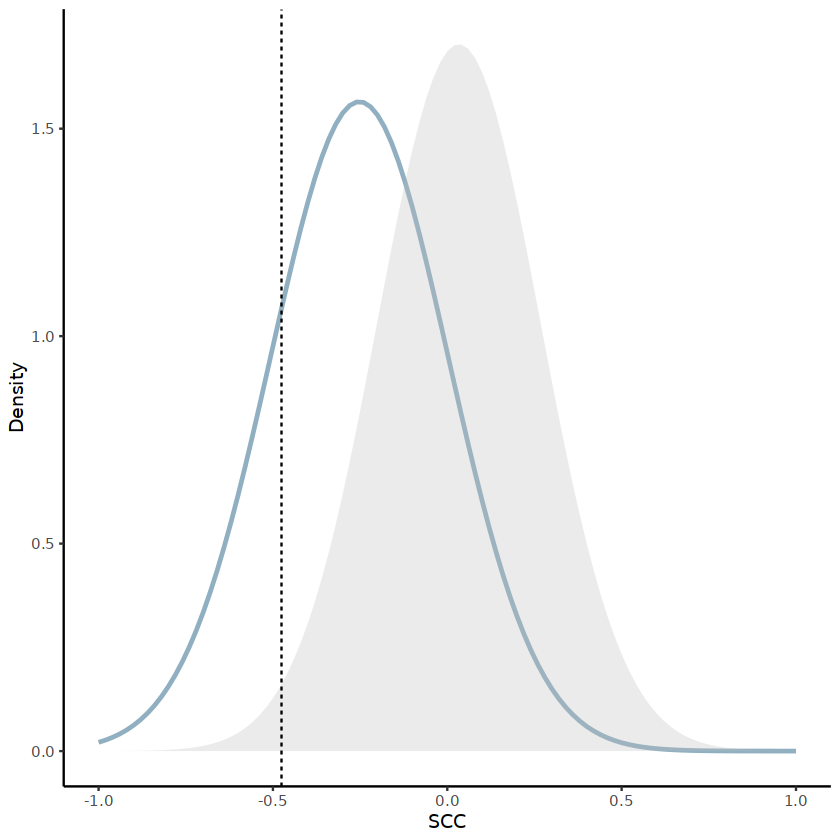

In [18]:
### Plot density
cutoff <- cutoff2
t1 <- dp_cor_df %>%
ggplot(aes(x = k27me3)) + 
# geom_histogram(aes(y = ), fill = colfunc2(4)[2], alpha = 0.5, color = "white") + 
# geom_histogram(data = dp_cor_bg, aes(x = as.numeric(k27ac_bg), y = after_stat(count / sum(count))), fill = "grey", alpha = 0.5, color = "white") + 
stat_function(aes(group = 1), fun = dnorm, 
              args = list(mean = mean(dp_cor_df$k27me3), sd = sd(dp_cor_df$k27me3)),
              col = colfunc2(4)[1], size = 1, alpha = 0.6) + 
stat_function(data = dp_cor_bg_df, aes(x = k27me3_bg, group = 1), fun = dnorm, geom = 'area',
              args = list(mean = mean(dp_cor_bg_df$k27me3_bg), sd = sd(dp_cor_bg_df$k27me3_bg)),
              size = 1, fill = "grey", alpha = 0.3) + 
# geom_ribbon(aes(ymin = min(fb), ymax = fb), fill = 'red', alpha=0.3, position = "identity") + 
# stat_function(data = dp_cor_bg1, aes(x = k27me3_bg, group = 1), fun = dnorm, 
#               args = list(mean = mean(dp_cor_bg1$k27me3_bg), sd = sd(dp_cor_bg1$k27me3_bg)),
#               col = "grey", size = 1) + 
geom_vline(xintercept = cutoff, linetype = 2, ) +
theme_classic() + xlab("SCC") + ylab("Density") + xlim(c(-1,1))
t1

## Plot density

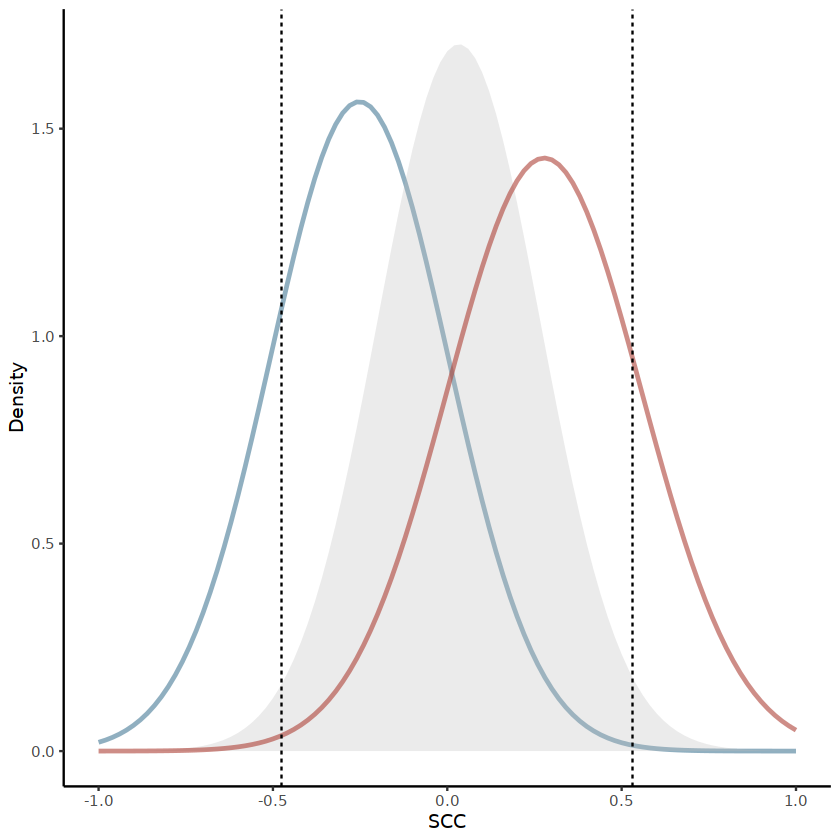

In [19]:
df_cor_df2 <- readRDS("cicero/CEMBA_ovlp/DPT_FC_H3K27ac_CEMBA_cCRE_cicero_distal_peak_RNA_SCC.rds")
df_cor_df_bg2 <- readRDS("cicero/CEMBA_ovlp/DPT_FC_H3K27ac_CEMBA_cCRE_cicero_distal_peak_RNA_SCC_background.rds")

t1 <- dp_cor_df %>%
ggplot(aes(x = k27me3)) + 
stat_function(aes(group = 1), fun = dnorm, 
              args = list(mean = mean(dp_cor_df$k27me3), sd = sd(dp_cor_df$k27me3)),
              col = colfunc2(4)[1], size = 1, alpha = 0.6) + 
stat_function(data = dp_cor_bg_df, aes(x = k27me3_bg, group = 1), fun = dnorm, geom = 'area',
              args = list(mean = mean(dp_cor_bg_df$k27me3_bg), sd = sd(dp_cor_bg_df$k27me3_bg)),
              size = 1, fill = "grey", alpha = 0.3) + 
stat_function(data = df_cor_df2, aes(x = k27ac, group = 1), , fun = dnorm, 
              args = list(mean = mean(df_cor_df2$k27ac), sd = sd(df_cor_df2$k27ac)),
              col = colfunc2(4)[2], size = 1, alpha = 0.6) + 
# stat_function(data = df_cor_df_bg2, aes(x = k27ac_bg, group = 1), fun = dnorm, geom = 'area',
#               args = list(mean = mean(df_cor_df_bg2$k27ac_bg), sd = sd(df_cor_df_bg2$k27ac_bg)),
#               size = 1, fill = "black", alpha = 0.3) + 
geom_vline(xintercept = 0.531, linetype = 2, ) +
geom_vline(xintercept = -0.475, linetype = 2) + 
theme_classic() + xlab("SCC") + ylab("Density") + xlim(c(-1,1))
t1

## Compare with Paired-Tag

In [ ]:
### H3K27ac

Warning message in ks.test(pt_df_cor$k27ac, pt_df_cor_bg$k27ac_bg):
“p-value will be approximate in the presence of ties”



	Two-sample Kolmogorov-Smirnov test

data:  pt_df_cor$k27ac and pt_df_cor_bg$k27ac_bg
D = 0.25566, p-value < 2.2e-16
alternative hypothesis: two-sided


Warning message in ks.test(dpt_df_cor$k27ac, dpt_df_cor_bg$k27ac_bg):
“p-value will be approximate in the presence of ties”



	Two-sample Kolmogorov-Smirnov test

data:  dpt_df_cor$k27ac and dpt_df_cor_bg$k27ac_bg
D = 0.38857, p-value < 2.2e-16
alternative hypothesis: two-sided


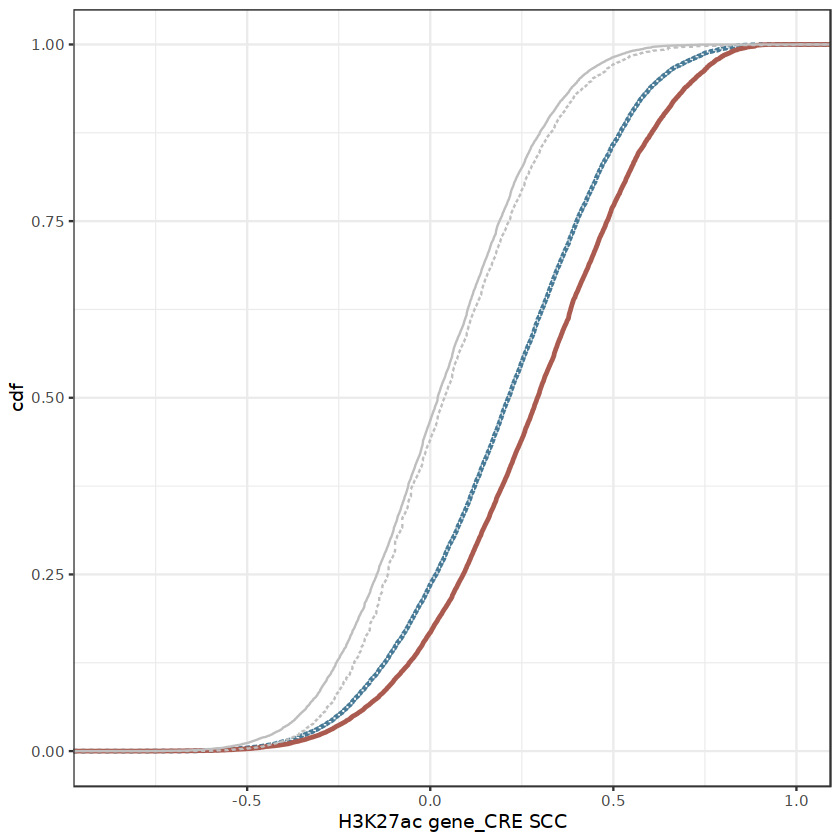

In [20]:
pt_df_cor <- readRDS("cicero/CEMBA_ovlp/PT_FC_H3K27ac_CEMBA_cCRE_cicero_distal_peak_RNA_SCC.rds")
dpt_df_cor <- readRDS("cicero/CEMBA_ovlp/DPT_FC_H3K27ac_CEMBA_cCRE_cicero_distal_peak_RNA_SCC.rds")

pt_df_cor_bg <- readRDS("cicero/CEMBA_ovlp/PT_FC_H3K27ac_CEMBA_cCRE_cicero_distal_peak_RNA_SCC_background.rds")
dpt_df_cor_bg <- readRDS("cicero/CEMBA_ovlp/DPT_FC_H3K27ac_CEMBA_cCRE_cicero_distal_peak_RNA_SCC_background.rds")

ks.test(pt_df_cor$k27ac, pt_df_cor_bg$k27ac_bg)
ks.test(dpt_df_cor$k27ac, dpt_df_cor_bg$k27ac_bg)

t1 <- pt_df_cor %>%
ggplot(aes(k27ac)) + 
stat_ecdf(geom = "step", color = colfunc2(6)[1], lwd = 1, linetype = "dashed") + 
stat_ecdf(data = dpt_df_cor, aes(x = k27ac), geom = "step", color = colfunc2(6)[2], lwd = 1) + 
stat_ecdf(data = pt_df_cor_bg, aes(x = k27ac_bg), geom = "step", color = "grey", linetype = "dashed") + 
stat_ecdf(data = dpt_df_cor_bg, aes(x = k27ac_bg), geom = "step", color = "grey") + 
theme_bw() + 
ylab("cdf") + xlab("H3K27ac gene_CRE SCC")
t1

Warning message in ks.test(pt_df_cor$k27me3, pt_df_cor_bg$k27me3_bg):
“p-value will be approximate in the presence of ties”



	Two-sample Kolmogorov-Smirnov test

data:  pt_df_cor$k27me3 and pt_df_cor_bg$k27me3_bg
D = 0.10176, p-value < 2.2e-16
alternative hypothesis: two-sided


Warning message in ks.test(dpt_df_cor$k27me3, dpt_df_cor_bg$k27me3_bg):
“p-value will be approximate in the presence of ties”



	Two-sample Kolmogorov-Smirnov test

data:  dpt_df_cor$k27me3 and dpt_df_cor_bg$k27me3_bg
D = 0.44798, p-value < 2.2e-16
alternative hypothesis: two-sided


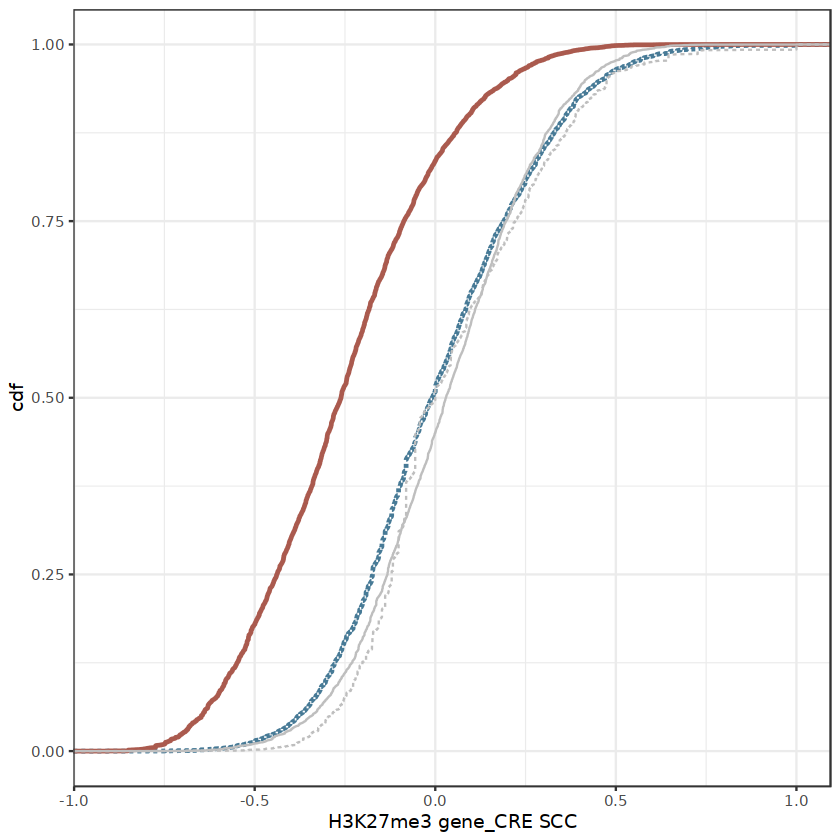

In [21]:
pt_df_cor <- readRDS("../cicero/CEMBA_ovlp/PT_FC_H3K27me3_CEMBA_cCRE_cicero_distal_peak_RNA_SCC.rds")
dpt_df_cor <- readRDS("../cicero/CEMBA_ovlp/DPT_FC_H3K27me3_CEMBA_cCRE_cicero_distal_peak_RNA_SCC.rds")

pt_df_cor_bg <- readRDS("../cicero/CEMBA_ovlp/PT_FC_H3K27me3_CEMBA_cCRE_cicero_distal_peak_RNA_SCC_background.rds")
dpt_df_cor_bg <- readRDS("../cicero/CEMBA_ovlp/DPT_FC_H3K27me3_CEMBA_cCRE_cicero_distal_peak_RNA_SCC_background.rds")

ks.test(pt_df_cor$k27me3, pt_df_cor_bg$k27me3_bg)
ks.test(dpt_df_cor$k27me3, dpt_df_cor_bg$k27me3_bg)

t1 <- pt_df_cor %>%
ggplot(aes(k27me3)) + 
stat_ecdf(geom = "step", color = colfunc2(6)[1], lwd = 1, linetype = "dashed") + 
stat_ecdf(data = dpt_df_cor, aes(x = k27me3), geom = "step", color = colfunc2(6)[2], lwd = 1) + 
stat_ecdf(data = pt_df_cor_bg, aes(x = k27me3_bg), geom = "step", color = "grey", linetype = "dashed") + 
stat_ecdf(data = dpt_df_cor_bg, aes(x = k27me3_bg), geom = "step", color = "grey") + 
theme_bw() + 
ylab("cdf") + xlab("H3K27me3 gene_CRE SCC")
t1

# Check cell type specific cCRE-genes pairs: H3K27ac/me3 signal on distal peaks, and GE signal on putative target genes

### H3K27ac

In [27]:
dp_cor <- readRDS("cicero/CEMBA_ovlp/DPT_FC_H3K27ac_CEMBA_cCRE_cicero_distal_peak_RNA_SCC.rds")
k27ac_nmf <- read.table("NMF_peaks_genes/H3K27ac_CEMBA_cCRE/res/predicted_CRE_cluster.r20n10.statW", 
                        row.names = 1, header = F)
k27ac_nmf_name <- read.table("NMF_peaks_genes/H3K27ac_CEMBA_cCRE/res/predicted_CRE_cluster.r20n10.statH", 
                        row.names = 1, header = F)
colnames(k27ac_nmf) <- c("index","class0","contributes","fs","selt_fs_list","selt_med_list")
k27ac_nmf[,c("chr1", "start1", "end1")] <- stringr::str_split_fixed(rownames(k27ac_nmf), pattern = "-", n = 3)

tss <- read.table("/projects/ps-renlab/y2xie/projects/genome_ref/mm10.tss.vm25.2k.bed")
tss$cood <- paste(tss$V1, tss$V2, tss$V3, sep = "-")
dp_cor$tss <- tss[match(dp_cor$gene, tss$V6), "cood"]

### valid pairs!!!
cutoff = 0.531
dp_cor_valid <- dp_cor[dp_cor$k27ac > cutoff,]
dp_cor_valid <- dp_cor_valid %>% tibble::rowid_to_column("pair") %>% mutate(pair = paste0("distal_pair_", pair))
dp_cor_valid[,c("chr1", "start1", "end1")] <- stringr::str_split_fixed(dp_cor_valid$peaks, pattern = "-", n = 3)
dp_cor_valid[,c("chr2", "start2", "end2")] <- stringr::str_split_fixed(dp_cor_valid$tss, pattern = "-", n = 3)
write.table(dp_cor_valid[,c("chr1", "start1", "end1", "chr2", "start2", "end2", "k27ac", "pair")], 
            file = "DPT_FC_H3K27a_CEMBA_cCRE_cicero_distal_CRE_gene_FDR005.bedpe",
            sep = "\t", quote  = F, row.names = F, col.names = F)

dp_cor_valid$class1 <- dp_cor_valid$class2 <- NA
dim(dp_cor_valid)

### intersect cCRE-gene pairs with peaks module
dp_cor_valid[match(intersect(dp_cor_valid$peaks, rownames(k27ac_nmf)), dp_cor_valid$peaks), "class1"] <- k27ac_nmf[intersect(dp_cor_valid$peaks, rownames(k27ac_nmf)), "class0"]

### get class, match names
dp_cor_valid <- dp_cor_valid[!is.na(dp_cor_valid$class2) | !is.na(dp_cor_valid$class1), ]
dp_cor_valid$class <- dp_cor_valid$class1
dp_cor_valid$class <- rownames(k27ac_nmf_name)[match(dp_cor_valid$class, k27ac_nmf_name$V4)]

[1] 20241    13

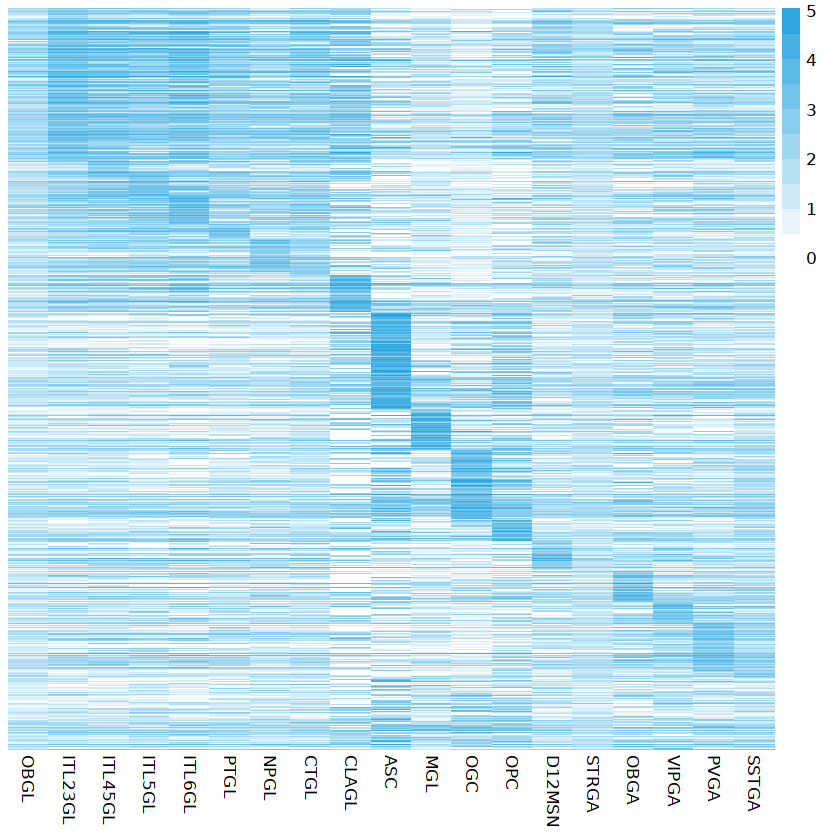

In [28]:
plot <- readRDS("FC_H3K27ac_CEMBA_cCRE_by_annotation.mtx.rds")
plot[plot > 32] <- 32

rorder <- c("OBGL", "ITL23GL", "ITL45GL", "ITL5GL", "ITL6GL", "PTGL", "NPGL", "CTGL", "CLAGL", 
            "ASC", "MGL", "OGC", "OPC", "D12MSN", "STRGA", "OBGA", "VIPGA", "PVGA", "SSTGA")
corder <- k27ac_nmf[intersect(dp_cor_valid$peaks, rownames(k27ac_nmf)), ] %>% 
mutate(class0 = factor(class0, levels = k27ac_nmf_name[rorder, "V4"])) %>% 
dplyr::arrange(class0) %>%
rownames

t1 <- log2(plot[corder, rorder]+1) %>%
pheatmap(cluster_rows = F, cluster_cols = F, 
         color = colorRampPalette(c("white", "#2EA7E0"))(10), show_rownames = FALSE)

write.table(plot[corder, rorder], "DPT_FC_H3K27ac_CEMBA_cCRE_cicero_distal_peak_RNA_sigPeak_at_cCRE_H3K27ac.txt",
           row.names = T, col.names = T, sep = "\t", quote = F)

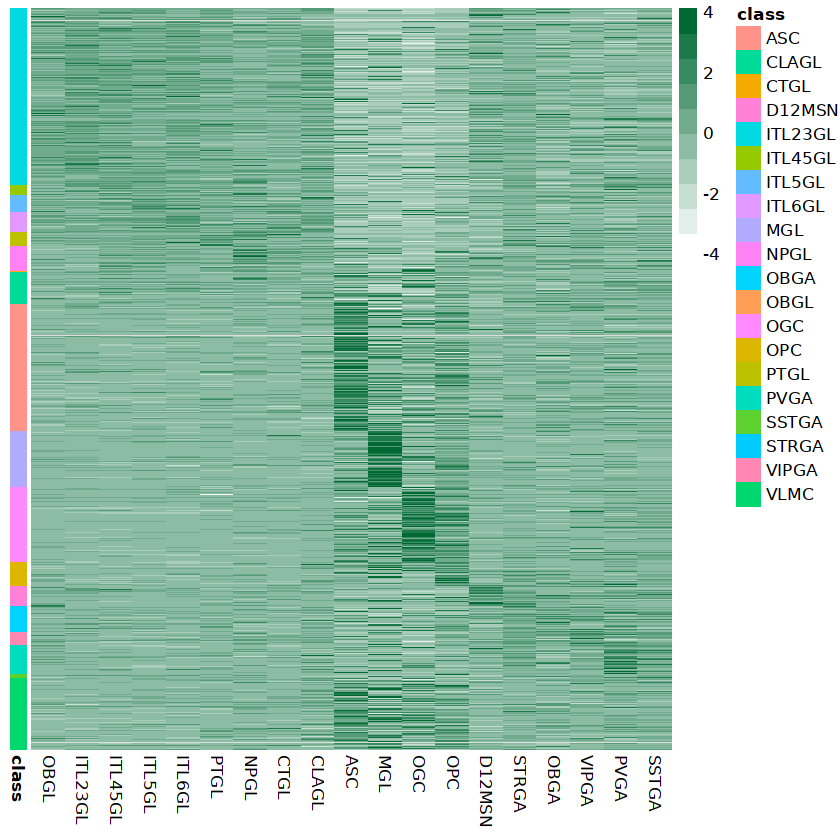

In [31]:
### plot correalted gene expression!
gorder <- unique((dp_cor_valid[match(corder, dp_cor_valid$peaks), "gene"]))
gorder <- gorder[!is.na(gorder)]

plot <- rna
cutoff1 <- quantile(plot, probs = 0.05, na.rm = T)
cutoff2 <- quantile(plot, probs = 0.99, na.rm = T)
plot[plot < cutoff1] <- cutoff1
plot[plot > cutoff2] <- cutoff2

groupn <- distinct((dp_cor_valid[match(corder, dp_cor_valid$peaks), c("class", "gene")]))
group_anno <- groupn[match(unique(groupn$gene), groupn$gene),] %>% tibble::rownames_to_column("id") %>%
tibble::column_to_rownames("gene") %>%
dplyr::select(class)

tmp <- log2(plot[gorder, rorder]+1) %>%
pheatmap(scale = "row", cluster_rows = F, cluster_cols = F, annotation_row = group_anno,
         color = colorRampPalette(c("white", "#006934"))(10), show_rownames = FALSE)

### H3K27me3

In [32]:
dp_cor <- readRDS("cicero/CEMBA_ovlp/DPT_FC_H3K27me3_CEMBA_cCRE_cicero_distal_peak_RNA_SCC.rds")
dp_cor$tss <- tss[match(dp_cor$gene, tss$V6), "cood"]

### valid pairs: FDR < 0.05
dp_cor_valid <- dp_cor[dp_cor$k27me3 < -0.475,]
dim(dp_cor_valid)
dp_cor_valid <- dp_cor_valid %>% tibble::rowid_to_column("pair") %>% mutate(pair = paste0("distal_pair_", pair))

k27me3_nmf <- read.table("../NMF_peaks_genes/H3K27me3_CEMBA_cCRE/res/predicted_CRE_cluster.r20n10.statW", 
                        row.names = 1, header = F)
k27me3_nmf_name <- read.table("../NMF_peaks_genes/H3K27me3_CEMBA_cCRE/res/predicted_CRE_cluster.r20n10.statH", 
                        row.names = 1, header = F)
colnames(k27me3_nmf) <- c("index","class0","contributes","fs","selt_fs_list","selt_med_list")

dp_cor_valid[,c("chr1", "start1", "end1")] <- stringr::str_split_fixed(dp_cor_valid$peaks, pattern = "-", n = 3)
dp_cor_valid[,c("chr2", "start2", "end2")] <- stringr::str_split_fixed(dp_cor_valid$tss, pattern = "-", n = 3)
write.table(dp_cor_valid[,c("chr1", "start1", "end1", "chr2", "start2", "end2", "k27me3", "pair")], 
            file = "DPT_FC_H3K27me3_CEMBA_cCRE_cicero_distal_CRE_gene_FDR005.bedpe",
            sep = "\t", quote  = F, row.names = F, col.names = F)

dp_cor_valid$class1 <- dp_cor_valid$class2 <- NA
dp_cor_valid[match(intersect(dp_cor_valid$peaks, rownames(k27me3_nmf)), dp_cor_valid$peaks), "class1"] <- k27me3_nmf[intersect(dp_cor_valid$peaks, rownames(k27me3_nmf)), "class0"]
dp_cor_valid <- dp_cor_valid[!is.na(dp_cor_valid$class2) | !is.na(dp_cor_valid$class1), ]
dp_cor_valid$class <- dp_cor_valid$class1
dp_cor_valid$class <- rownames(k27me3_nmf_name)[match(dp_cor_valid$class, k27me3_nmf_name$V4)]

[1] 4738    4

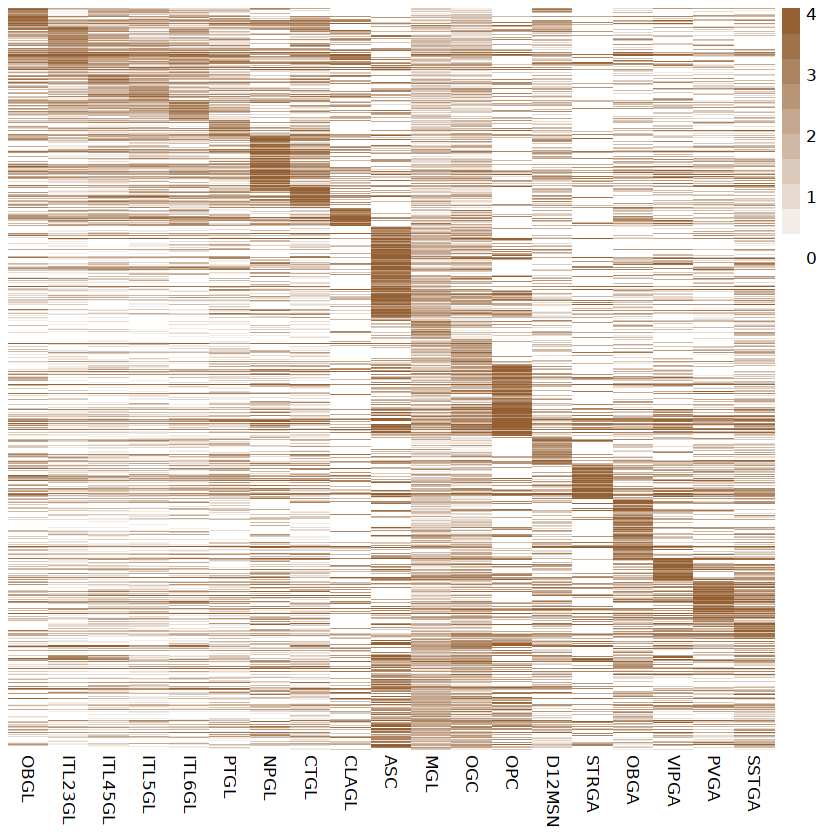

In [33]:
plot <- readRDS("FC_H3K27me3_CEMBA_cCRE_by_annotation.mtx.rds")

cutoff1 <- quantile(plot, probs = 0.05, na.rm = T)
cutoff2 <- quantile(plot, probs = 0.95, na.rm = T)
cutoff2 = 16
plot[plot > cutoff2] <- cutoff2
corder <- k27me3_nmf[intersect(dp_cor_valid$peaks, rownames(k27me3_nmf)), ] %>% 
mutate(class0 = factor(class0, levels = k27me3_nmf_name[rorder, "V4"])) %>% 
dplyr::arrange(class0) %>%
rownames

t1 <- log2(plot[corder, rorder]+1) %>%
pheatmap(cluster_rows = F, cluster_cols = F, 
         color = colorRampPalette(c("white", "#956134"))(10), show_rownames = FALSE)
write.table(plot[corder, rorder], "DPT_FC_H3K27me3_CEMBA_cCRE_cicero_distal_peak_RNA_sigPeak_at_cCRE_H3K27me3.txt",
           row.names = T, col.names = T, sep = "\t", quote = F)


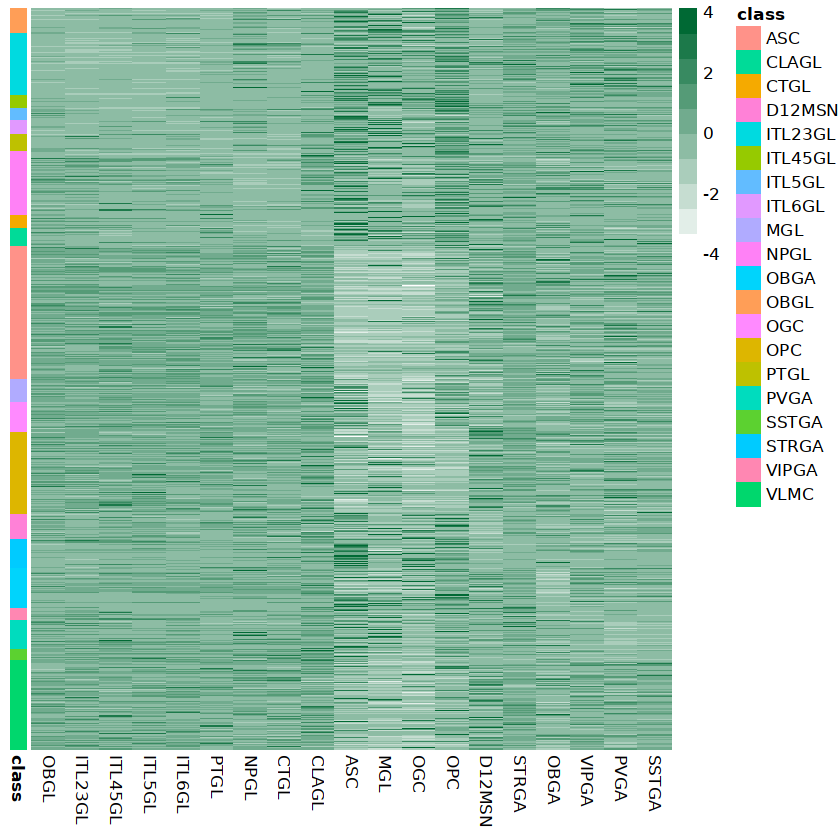

In [34]:
### plot correalted gene expression!
gorder <- unique((dp_cor_valid[match(corder, dp_cor_valid$peaks), "gene"]))
gorder <- gorder[!is.na(gorder)]

plot <- rna
cutoff1 <- quantile(plot, probs = 0.05, na.rm = T)
cutoff2 <- quantile(plot, probs = 0.99, na.rm = T)
plot[plot < cutoff1] <- cutoff1
plot[plot > cutoff2] <- cutoff2

groupn <- distinct((dp_cor_valid[match(corder, dp_cor_valid$peaks), c("class", "gene")]))
group_anno <- groupn[match(unique(groupn$gene), groupn$gene),] %>% tibble::rownames_to_column("id") %>%
tibble::column_to_rownames("gene") %>%
dplyr::select(class)

tmp <- log2(plot[gorder, rorder]+1) %>%
pheatmap(scale = "row", cluster_rows = F, cluster_cols = F, annotation_row = group_anno,
         color = colorRampPalette(c("white", "#006934"))(10), show_rownames = FALSE)


# Check whether pairs at loop anchors are STRONGER?
bedtools pairtobed

### H3K27ac


	Wilcoxon rank sum test with continuity correction

data:  dp_cor[dp_cor$loop == "True", "V7"] and dp_cor[dp_cor$loop == "False", "V7"]
W = 53383382, p-value = 1.504e-11
alternative hypothesis: true location shift is not equal to 0


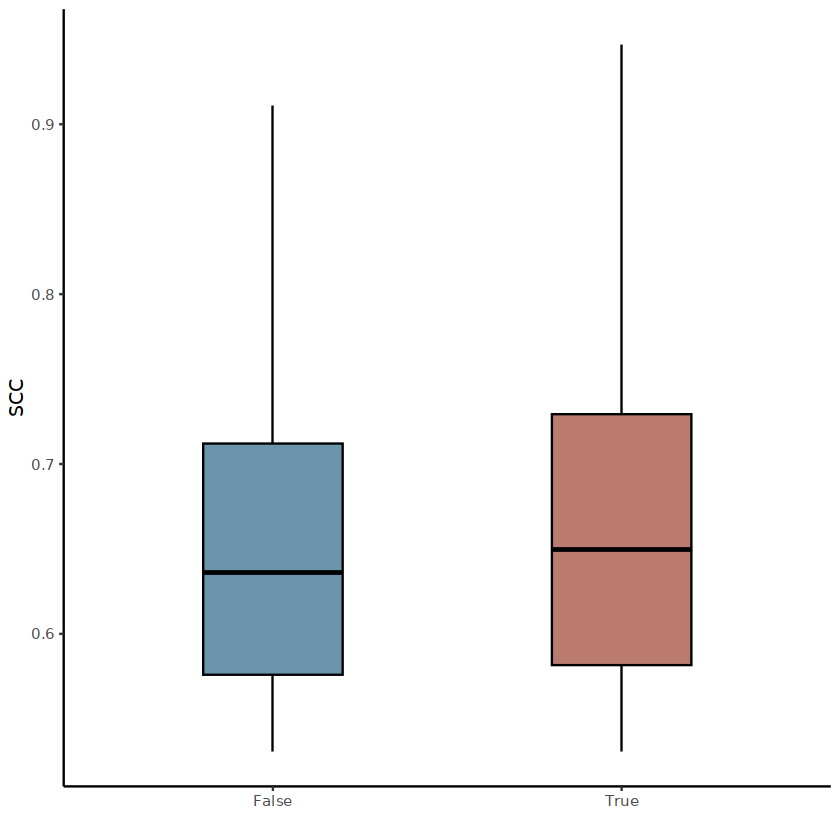

In [38]:
### read pairs and select in / out pair
dp_cor <- read.table("DPT_FC_H3K27a_CEMBA_cCRE_cicero_distal_CRE_gene_FDR005.bedpe")
dp_cor_loop <- read.table("DPT_FC_H3K27a_CEMBA_cCRE_cicero_distal_CRE_gene_FDR005_at_loop.bedpe")

dp_cor$loop <- "False"
dp_cor[dp_cor$V8 %in% dp_cor_loop$V8, ]$loop <- "True"
t1 <- dp_cor %>%
ggplot(aes(x = loop, y = V7)) + 
geom_boxplot(aes(fill = loop), width=0.4, color="black", alpha=0.8, coef = 1.5, outlier.shape = NA) + 
theme_classic() + 
scale_fill_manual(values = colfunc2(6)) + 
ylab("SCC") + xlab("") + NoLegend()

t1

### test?
wilcox.test(x = dp_cor[dp_cor$loop == "True", "V7"], 
           y = dp_cor[dp_cor$loop == "False", "V7"])

### H3K27me3


	Wilcoxon rank sum test with continuity correction

data:  dp_cor[dp_cor$loop == "True", "V7"] and dp_cor[dp_cor$loop == "False", "V7"]
W = 2902055, p-value = 0.01615
alternative hypothesis: true location shift is not equal to 0


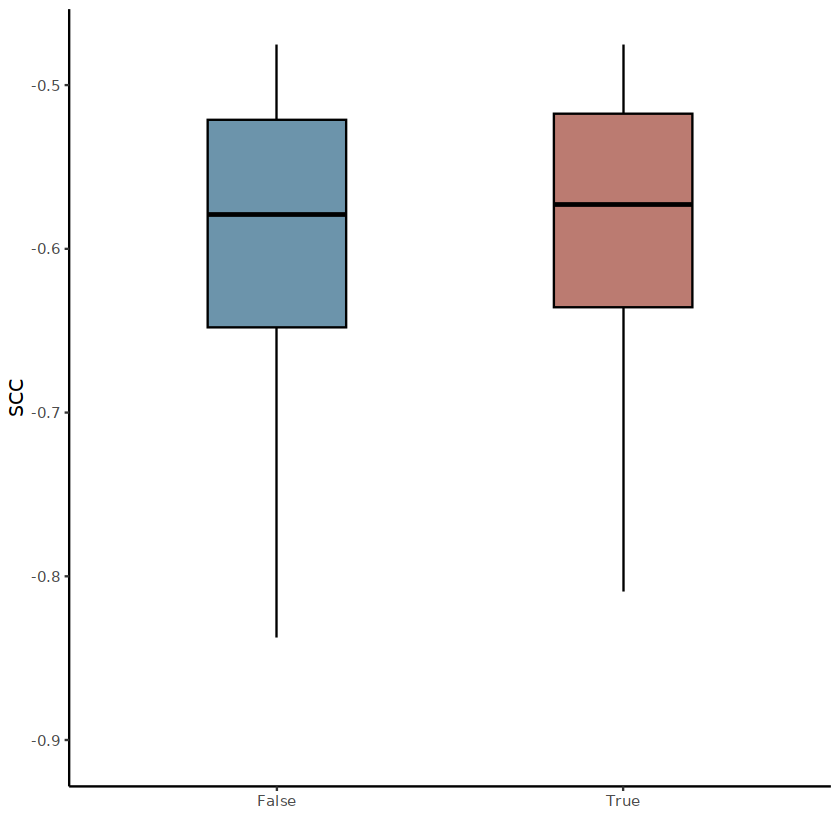

In [39]:
dp_cor <- read.table("DPT_FC_H3K27me3_CEMBA_cCRE_cicero_distal_CRE_gene_FDR005.bedpe")
dp_cor_loop <- read.table("DPT_FC_H3K27me3_CEMBA_cCRE_cicero_distal_CRE_gene_FDR005_at_loop.bedpe")

dp_cor$loop <- "False"
dp_cor[dp_cor$V8 %in% dp_cor_loop$V8, ]$loop <- "True"
t1 <- dp_cor %>%
ggplot(aes(x = loop, y = V7)) + 
geom_boxplot(aes(fill = loop), width=0.4, color="black", alpha=0.8, coef = 1.5, outlier.shape = NA) + 
theme_classic() + 
scale_fill_manual(values = colfunc2(6)) + 
ylab("SCC") + xlab("") + NoLegend()

t1
wilcox.test(x = dp_cor[dp_cor$loop == "True", "V7"], 
           y = dp_cor[dp_cor$loop == "False", "V7"])